In [2]:
from pathlib import Path

DNA_PROCESSED_DIR = Path("/local/scratch/carlyn.1/dna/processed/chromosome")
PHENO_PROCESSED_DIR = Path("/local/scratch/carlyn.1/dna/colors/processed/")

In [3]:
import numpy as np
import pandas as pd

from gtp.dataloading.tools import align_data

erato_key = "chrom1801"
melpomene_key = "Hmel218003o_optix"

dna_data = np.load(DNA_PROCESSED_DIR / "erato" / erato_key / "ml_ready.npy")
dna_camids = np.load(DNA_PROCESSED_DIR / "erato" / erato_key / "camids.npy")
pheno_data = pd.read_csv(PHENO_PROCESSED_DIR / "erato_forewings_color_3" / "data.csv")

dna_data, dna_camids, pheno_data = align_data(dna_data, dna_camids, pheno_data)


In [4]:
pheno_data.head()

,camid,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC471,PC472,PC473,PC474,PC475,PC476,PC477,PC478,PC479,PC480
19,CAM016046,87.775689,-7.798241,7.223415,0.877818,6.606137,3.051808,1.270934,-4.584790,0.857896,...,0.072983,0.059340,0.427551,-0.080983,-0.353217,-0.063252,-0.494995,0.320205,0.179995,1.068365e-14
20,CAM016047,91.029904,-7.736500,8.068281,-6.399384,1.146693,3.327450,1.157791,1.365010,0.942157,...,0.128530,0.203373,-0.053031,0.264846,-0.028507,0.129870,-0.101843,-0.402905,-0.385660,8.379939e-15
21,CAM016048,92.995416,-8.064213,7.145759,-8.182499,0.548070,1.450270,1.705121,-0.683711,-0.370126,...,0.619264,0.340842,0.463500,0.119002,-0.200975,-0.010850,-0.120985,0.387206,0.114293,5.548870e-15
133,CAM016525,-12.878990,-15.433518,-5.901145,5.198437,-1.992308,3.823715,-3.133228,-0.400863,-4.057671,...,0.410142,-1.251335,1.399170,-0.614210,1.341941,-0.642795,-0.130378,0.025240,0.267433,2.234898e-15
137,CAM016553,-1.809578,3.157413,-9.787084,12.733434,-5.306058,11.629505,-0.167564,11.295023,-2.204322,...,0.737243,-0.017419,1.071691,0.687248,0.305524,0.251478,-0.245891,0.083014,0.053644,4.416530e-15


Running Linear regression on SNPS: 100%|██████████| 57437/57437 [00:13<00:00, 4380.59it/s]


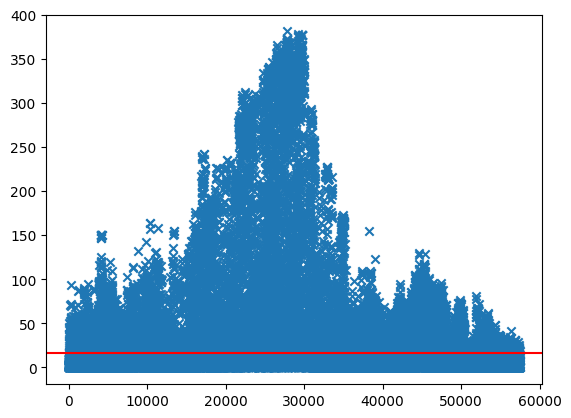

In [6]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from tqdm import tqdm

# 1, 0, 0 = 0 | 0, 1, 0 = 1 | 0, 0, 1 = 2
snp_categories = (dna_data.astype(np.uint8) * np.array([0, 1, 2])).sum(2)
num_categories = len(np.unique(snp_categories, return_counts=True)[0])
assert num_categories == 3, f"There should only be 3 categories. {num_categories} were detected"

pvals = []
for snp in tqdm(range(snp_categories.shape[1]), desc="Running Linear regression on SNPS"):
    if len(np.unique(snp_categories[:, snp], return_counts=True)[0]) > 1:
        result = stats.linregress(snp_categories[:, snp], pheno_data.PC1)
        pval = result.pvalue
        #data = np.concatenate((snp_categories[:, snp:snp+1], pheno_data.PC1.to_numpy()[:, np.newaxis], np.zeros_like(pheno_data.PC1.to_numpy()[:, np.newaxis])), axis=1)
        #df = pd.DataFrame(data, columns=["SNP", "PC1", "psuedo_group"])
        #md = smf.mixedlm("SNP ~ PC1", df, groups=df["psuedo_group"])
        #mdf = md.fit(method=["lbfgs"])
        #pval = mdf.pvalues.PC1
    else:
        pval = 1.0
    pvals.append(pval)
    
plt.figure()
y = -np.log(np.array(pvals))
plt.scatter(np.arange(0, len(y)), y, marker='x')
bonferroni_correction_pval = 5e-8
plt.axhline(y=-np.log(bonferroni_correction_pval), color='r', linestyle='-')
plt.show()